# Hyperparameter Optimization Tutorial <a class="tocSkip">
    
The lab client library integrates various hyperparameter optimization libraries to make it simple to tune hyperparameters.

**In this notebook:**

* Create fasttext classification model based on Facebooks Fasttext Implementation and optimize Hyperparameters via:
    * [Sklearn Grid Search](#Run-Simple-Grid-Search)
    * [Sklearn Random Search](#Run-Simple-Random-Search)
    * [Hyperopt Optimizer](#Run-Hyperopt-Optimizer)
    * [Skopt Optimizer](#Run-Skopt-Optimizer)
    * [Optuna Optimizer](#Run-Optuna-Optimizer)

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies
- _Please use a Python 3 kernel for the notebook_

To build fastText for Python:
``` bash
%%bash
mkdir /resources/fasttext-0-2
cd /resources/fasttext-0-2
git clone https://github.com/facebookresearch/fastText.git
cd fastText
pip install .
```

### Import Dependencies

In [ ]:
# System libraries
from __future__ import division, print_function
import logging, os, sys, time

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

%load_ext autoreload
%autoreload 2

# Third-party libraries
import numpy as np
import pandas as pd

import fastText

# Lab libraries
from lab_client import Environment
from lab_client.commons import file_utils

### Initialize Environment

<div class="alert alert-info">
To run this code you need to have created a project within the Lab instance and replace LAB_PROJECT with your project!
</div>

In [ ]:
# Initialize environment
env = Environment(project="LAB_PROJECT"  # Lab project you want to work on
                  # Only required in stand-alone workspace deployments
                  # lab_endpoint="LAB_ENDPOINT", # Lab endpoint url: e.g. http://10.2.3.45:8091
                  # lab_api_token="LAB_API_TOKEN"
                 )

# Initialize experiment
exp = env.create_experiment('Hyperopt Tutorial')

## Load Data
Download, explore, and prepare all required data for the experiment in this section.

<div class="alert alert-info">
To run this code you need to have uploaded <a href="/docs/walkthrough/data/download-dataset.html" target="_blank"><strong>this dataset</strong></a> to the Lab instance!
</div>

In [ ]:
# Get data from remote storage and read into basic pandas dataframe
dataset_key = 'datasets/news-categorized.csv'
text_corpus_path = env.get_file(dataset_key)

# Load dataset via pandas
df = pd.read_csv(text_corpus_path, sep=";")

# Configure dataset transfomration
dataset_config = {
    'train_size':0.75
}

# Split the dataset into train (95%), and test (5%) based on dataset configuration
train_df, test_df = np.split(df.sample(frac=1, random_state=2), [int(dataset_config['train_size']*len(df))])

# Create training data file for fasttext - fasttext requires a text file as input
train_data_path = exp.create_file_path('train_fasttext.csv')
with open(train_data_path, 'w') as f:
    for index, row in train_df.iterrows():
        if row["label"] and row["text"]:
            f.write("__label__" + row["label"].strip() + ' ' +  str(row["text"]) +  '\n')

# Show sample
train_df.head()

## Define Model Training
Implementation of model training and unified model creation

In [ ]:
from unified_model.predefined_models.fasttext_models import FasttextClassifier

# use this if you are using the not preprocessed content
def create_unified_model(ft_model_path: str, model_name: str):
    def preprocess(data, **kwargs):
        return str(data)
    
    return FasttextClassifier(ft_classifier_path=ft_model_path, 
                              name=model_name, 
                              transform_func=preprocess)


def train(exp, params, artifacts):
    start = time.time()
    
    # train model
    model = fastText.train_supervised(
        input = artifacts['train_data_path'], 
        lr = params['learning_rate'],
        dim = params['vector_dim'],
        ws = params['window_size'],
        epoch = params['epochs'],
        minCount = params['min_count'],
        neg = params['negativ_sampling'],
        wordNgrams = params['word_ngrams'],
        bucket = params['bucket'],
        thread = params['threads'],
        verbose = 2
    )
    
    exp.log_metric("train_time", time.time()-start)
    
    # Save Model
    model_name = file_utils.get_filename(dataset_key) + "_ft_classifier"
    model_path = exp.create_file_path(model_name)
    
    model.save_model(model_path)
    unified_model = create_unified_model(model_path, model_name)
    
    # add trained model instance to experiment, so it can be accessed
    exp.add_artifact("trained_model", unified_model)
    
    # Test Model
    test_df = artifacts["test_data"]
    exp.log_metrics(unified_model.evaluate(test_df['text'].tolist(), test_df['label'].tolist(), per_label=False))
    
    # return the most descriptive metric (main objective) for the experiment
    accuracy = exp.metrics["micro_recall@k5"]
    print("Model training finished with accuracy: " + str(accuracy))
    return accuracy

## Run Param Optimization Experiments

### Default Experiment Configuration

In [ ]:
# Define parameter configuration for experiment run
params = {
    'learning_rate': 0.1,
    'vector_dim': 300,
    'window_size': 7,
    'epochs': 10,
    'min_count': 3,
    'negativ_sampling': 7,
    'word_ngrams': 1,
    'bucket': 0,
    'threads': 30
}

# Add dataset configuration to experiment parameters
params.update(dataset_config)

# add dataframes and file paths to experiment (will be logged and accesible within the experiment)
artifacts = {
    "train_data": train_df,
    "test_data": test_df,
    "train_data_path": train_data_path
}

### Optional: Run single training

In [ ]:
# Run experiment with default params and sync all metadata
exp.run_exp(train, params, artifacts)

### Run Simple Grid Search

Simple grid search using [Sklearn's ParamGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html). Please refer to this [user guide](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) on how to define the parameter space.

In [ ]:
from lab_client.utils.experiment_optimizer import GridSearchOptimizer

# Parameter Space for Hyperparameter Optimization
param_space = {
    'epochs': [5, 10, 20, 50],
    'min_count': [2, 5]
}

# Initialize and run Optimizer
optimizer = GridSearchOptimizer(exp)
experiments = optimizer.run(train, params, artifacts, param_space)
# Visualize Results
optimizer.plot_results()

### Run Simple Random Search

Simple random search using [Sklearn's ParamSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html). Please refer to this [user guide](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) on how to define the parameter space.

In [ ]:
from lab_client.utils.experiment_optimizer import RandomSearchOptimizer

# Parameter Space for Hyperparameter Optimization
param_space = {
    'epochs': [5, 10, 20, 50],
    'min_count': [2, 5]
}

# Initialize and run Optimizer
optimizer = RandomSearchOptimizer(exp)
experiments = optimizer.run(train, params, artifacts, param_space, max_evals=5)
# Visualize Results
optimizer.plot_results()

### Run Hyperopt Optimizer

Optimization based on the [hyperopt](http://hyperopt.github.io/hyperopt/) library using the Tree of Parzen Estimators (TPE) algorithm. Please refer to this [user guide](https://github.com/hyperopt/hyperopt/wiki/FMin) for information on how to define the parameter space and configure the optimizer.

In [ ]:
from lab_client.utils.experiment_optimizer import HyperoptOptimizer

# Parameter Space for Hyperparameter Optimization
from hyperopt import hp
param_space = {
    'epochs': hp.choice("epochs", [5, 10, 20, 50]),
    'min_count': hp.choice("min_count", [2,5])
}

# Initialize and run Optimizer
# You can provide additional named params to the HyperoptOptimizer that will be used in the fmin function
# Refer to this docu for information on available parameters: https://github.com/hyperopt/hyperopt/wiki/FMin
optimizer = HyperoptOptimizer(exp) 
experiments = optimizer.run(train, params, artifacts, param_space, max_evals=5)

# Visualize Results
optimizer.plot_results()

### Run Skopt Optimizer

Optimization based on the [skopt](https://scikit-optimize.github.io/) library that provides several algorithms for sequential model-based optimization. Please refer to this [user guide](https://scikit-optimize.github.io/optimizer/index.html) for information on how to define the parameter space and configure the optimizer.

In [ ]:
from lab_client.utils.experiment_optimizer import SkoptOptimizer

# Parameter Space for Hyperparameter Optimization
# Information on param space configuration: https://scikit-optimize.github.io/notebooks/hyperparameter-optimization.html
from skopt.space import Real, Integer, Categorical
param_space  = [
    Categorical([5, 10, 20, 50], name='epochs'),
    Categorical([2,5], name='min_count')
]

# Initialize and run Optimizer
# You can provide additional named params to the SkoptOptimizer to configure the minimize func of the selecte algorithm
# Refer to this docu for information on available parameters and algos: https://scikit-optimize.github.io/optimizer/index.html
optimizer = SkoptOptimizer(exp) 
experiments = optimizer.run(train, params, artifacts, param_space, max_evals=10)

# Visualize Results
optimizer.plot_results()

### Run Optuna Optimizer

Optimization based on the [optuna](https://github.com/pfnet/optuna) library that provides several algorithms parameter optimization. Please refer to this [user guide](https://optuna.readthedocs.io/en/stable/index.html) for information on how to define the parameter space and configure the optimizer.

In [ ]:
from lab_client.utils.experiment_optimizer import OptunaOptimizer

# Parameter Selection Function for Hyperparameter Optimization
# Information on param space configuration: https://optuna.readthedocs.io/en/stable/tutorial/configurations.html
def select_params(trial):
    param_selection = {}
    param_selection["epochs"] = trial.suggest_categorical('epochs', [5, 10, 20, 50])
    param_selection["min_count"] = trial.suggest_categorical('min_count', [2, 5])
    return param_selection

# Initialize and run Optimizer
# You can provide additional named params to the OptunaOptimizer to configure the optuna Study
# Refer to this docu for information on available parameters and algos: https://optuna.readthedocs.io/en/stable/index.html
optimizer = OptunaOptimizer(exp) 
experiments = optimizer.run(train, params, artifacts, select_params, max_evals=5)

# Visualize Results
optimizer.plot_results()

## How to choose the optimizer?

How to approach hyperparameter optimization ([source](https://www.quora.com/How-does-XGboost-work-and-what-is-the-best-way-to-optimize-the-parameters/answer/Yassine-Alouini)):

- Start with “good candidates” for the problem you are trying to solve. By good candidates, I mean standard values for hyperparameters that experts have been using and are known to yield good results. This is enough in a lot of cases. For a table of “good candidates”, I refer to this table from this great article .
- If the performance is still not acceptable by your standards, try random search and/or grid search. This type of approach is highly parallelizable (sometimes dubbed embarrassingly parallel problem) and you are only limited by the number of nodes you can set in your computing cluster.
- Finally, you can get clever by trying one the many Bayesian optimization techniques. If you are a Python user, I recommend trying hyperopt and/or skopt . Other similar libraries exist of course

To select the right optimizer for your use case please refer to the following table and look at the links below.

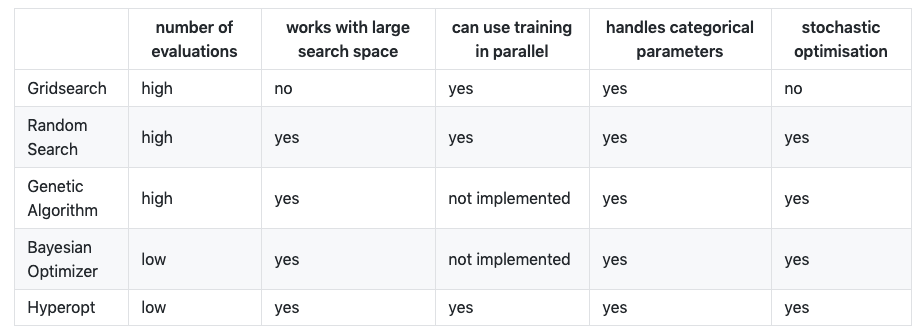

- [Optimizing the hyperparameter of which hyperparameter optimizer to use](https://roamanalytics.com/2016/09/15/optimizing-the-hyperparameter-of-which-hyperparameter-optimizer-to-use/)
- [Comparison among Hyper-parameter Optimizers](https://medium.com/@ramrajchandradevan/comparison-among-hyper-parameter-optimizers-cd37483cd47)
- [What methods do you prefer when performing hyperparameter optimization?](https://www.quora.com/What-methods-do-you-prefer-when-performing-hyperparameter-optimization)